# Business Questions:
##  Seattle AirBnB Dataset contains data about AirBnB listings in Seattle, calendar availability for each of these listings as well as user reviews on the listings. Using this dataset, I am going to attempt to answer the following business questions.


1.  Can we predict listing price using the available information ? 
2.  Can we find out the most important drivers to listing price? 
3.   Are the factors influencing price also influence reviews?






# Uploading all the files to google collab jupyter notebook

In [1]:
from google.colab import files
uploaded = files.upload()

Saving calendar.csv to calendar.csv
Saving listings.csv to listings.csv
Saving reviews.csv to reviews.csv


# Importing all the required libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import warnings
%matplotlib inline


## Read all the csv files into pandas dataframe

In [0]:
listings=pd.read_csv("listings.csv")
reviews=pd.read_csv("reviews.csv")
calender=pd.read_csv("calendar.csv")


## Checking the structure of files

In [4]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,2.016010e+13,1/4/2016,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,8/11/2011,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,1/4/2016,207,11/1/2011,1/2/2016,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,2.016010e+13,1/4/2016,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2/21/2013,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,1/4/2016,43,8/19/2013,12/29/2015,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [5]:
reviews.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...


In [6]:
calender.head(2)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00


## Cleaning the Listings data 

In [0]:
# creating days from datetime columns

date_list=['host_since', 'first_review',	'last_review', 'calendar_last_scraped']

from datetime import date

for x in date_list:  
  listings[x]=date.today() - pd.to_datetime(listings[x]).dt.date
  listings[x]=listings[x].dt.days


In [0]:
# Converting character columns to numeric by removing special symbols

change_list=['price',	'weekly_price',	'monthly_price' ,	'security_deposit',	'cleaning_fee', 'extra_people', 'host_response_rate','host_acceptance_rate', 'zipcode']

listings[change_list]=listings[change_list].apply(lambda x: x.str.replace('[$,%\n]','').astype("float"))

In [0]:
# Create some extra features based on amenities

listings['TV'] = listings.amenities.str.contains("tv", case=False).astype("int")
listings['Internet'] = listings.amenities.str.contains('internet|wireless', case=False).astype("int")
listings['Parking'] = listings.amenities.str.contains('parking', case=False).astype("int")
listings['Washer'] = listings.amenities.str.contains('washer', case=False).astype("int")
listings['AirCon'] = listings.amenities.str.contains('air condition|air conditioning', case=False).astype("int")

# Missing Values in Columns

In [10]:
# Finding the % of missing values within each column
data={ 'Count_Missing' : listings.isnull().sum(axis=0) , 
      'Perc_Missing'  : np.round(listings.isnull().sum(axis=0)*100/listings.shape[0],2)}

 
df_missing = pd.DataFrame(data)
df_missing.sort_values(by='Perc_Missing', ascending=False, inplace=True)
df_missing.head(5)

,Count_Missing,Perc_Missing
license,3818,100.00
square_feet,3721,97.46
monthly_price,2301,60.27
security_deposit,1952,51.13
weekly_price,1809,47.38


## Plotting Histogram of Missing Value 

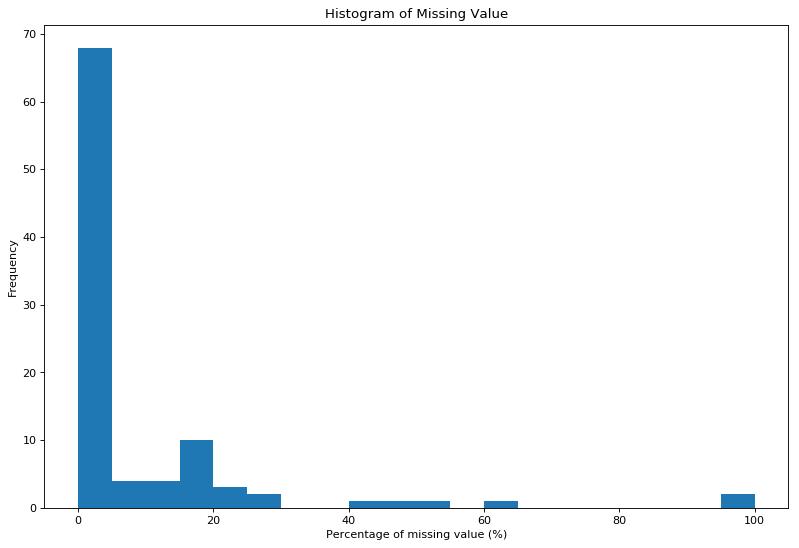

In [11]:

from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

# Investigate patterns in the amount of missing data in each column.
plt.hist(df_missing['Perc_Missing'], bins=20)
plt.xlabel('Percentage of missing value (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Missing Value')
plt.show()


# Drop Columns with More than 20% missing Values
## From the histogram above, most of variables look to have less than 20% missing values.

In [0]:
listings.drop(df_missing.loc[df_missing['Perc_Missing'] >= 20, :].index, axis=1, inplace=True)


# Splitting Character and Numeric Variables to do Cleaning, Transformation and Analysis separately

In [13]:
character_vars=listings.columns[listings.dtypes=="object"]

listings[character_vars]=listings[character_vars].apply(lambda x: x.str.upper())
character_vars

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'thumbnail_url', 'medium_url',
       'picture_url', 'xl_picture_url', 'host_url', 'host_name',
       'host_location', 'host_response_time', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities',
       'calendar_updated', 'has_availability', 'requires_license',
       'jurisdiction_names', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification'],
      dtype='object')

In [14]:
numeric_vars=listings.columns[listings.dtypes != "object"]
numeric_vars

Index(['id', 'scrape_id', 'host_id', 'host_since', 'host_response_rate',
       'host_listings_count', 'host_total_listings_count', 'zipcode',
       'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
       'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'TV', 'Internet', 'Parking', 'Washer', 'AirCon'],
      dtype='object')

# Handling Characater Variables

In [15]:
# Finding the unique levels in characater variables
cat_levels=  pd.DataFrame(listings.loc[:,character_vars].apply(lambda x: len(x.dropna().unique())), columns=['Unique_levels'] )

cat_levels

,Unique_levels
listing_url,3818
last_scraped,1
name,3785
summary,3476
space,3118
description,3742
experiences_offered,1
thumbnail_url,3498
medium_url,3498
picture_url,3818


In [16]:
# Character Columns with either 1 unique levels or more than 20 levels to be dropped in next step
cat_levels.loc[(cat_levels['Unique_levels'] == 1) |  (cat_levels['Unique_levels'] >20), :].index


Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'thumbnail_url', 'medium_url',
       'picture_url', 'xl_picture_url', 'host_url', 'host_name',
       'host_location', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_verifications', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'state', 'market', 'country_code', 'country',
       'amenities', 'calendar_updated', 'has_availability', 'requires_license',
       'jurisdiction_names'],
      dtype='object')

In [0]:
# drop all characater variables shortlisted
listings_rem_char=listings.drop(cat_levels.loc[(cat_levels['Unique_levels'] == 1) |  (cat_levels['Unique_levels'] >20), :].index.tolist(), axis=1)

listings_rem_char.drop(['city', 'smart_location'], axis=1, inplace=True)

In [0]:
# Replace missing value with mode

cols = listings_rem_char.columns[listings_rem_char.dtypes == "object"]

listings_rem_char[cols]=listings_rem_char[cols].fillna(listings_rem_char.mode().iloc[0])

In [19]:

# Checking if there are any missing values
listings_rem_char.loc[:,listings_rem_char.columns[listings_rem_char.dtypes == "object"]].isnull().sum(axis=0)

host_response_time                  0
host_is_superhost                   0
host_has_profile_pic                0
host_identity_verified              0
neighbourhood_group_cleansed        0
is_location_exact                   0
property_type                       0
room_type                           0
bed_type                            0
instant_bookable                    0
cancellation_policy                 0
require_guest_profile_picture       0
require_guest_phone_verification    0
dtype: int64

# Handling Numeric Variables

In [20]:
# Calculating Variance of Numeric Variables and dropping with eaither very low or very high variance - mostly single level or id variables
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold()
VarThr= selector.fit(listings.loc[:, numeric_vars].dropna())

VarThr.variances_.shape , listings.loc[:, numeric_vars].columns.shape

df_var= pd.DataFrame({ 'value' : VarThr.variances_, 'name': listings.loc[:, numeric_vars].columns})


df_var.loc[ (round(df_var['value'],2) == 0) | (df_var['value'] > 10**4), 'name'].values

array(['id', 'scrape_id', 'host_id', 'host_since', 'zipcode', 'latitude',
       'longitude', 'maximum_nights', 'availability_365',
       'calendar_last_scraped', 'first_review'], dtype=object)

In [0]:
# Creating dataframe after dropping columns
listings_rem_char_num=listings_rem_char.drop(df_var.loc[ (round(df_var['value'],2) == 0) | (df_var['value'] > 10**4), 'name'].values.tolist(), axis=1)

## 1.  Heat Map of Correlation between Numeric Variables

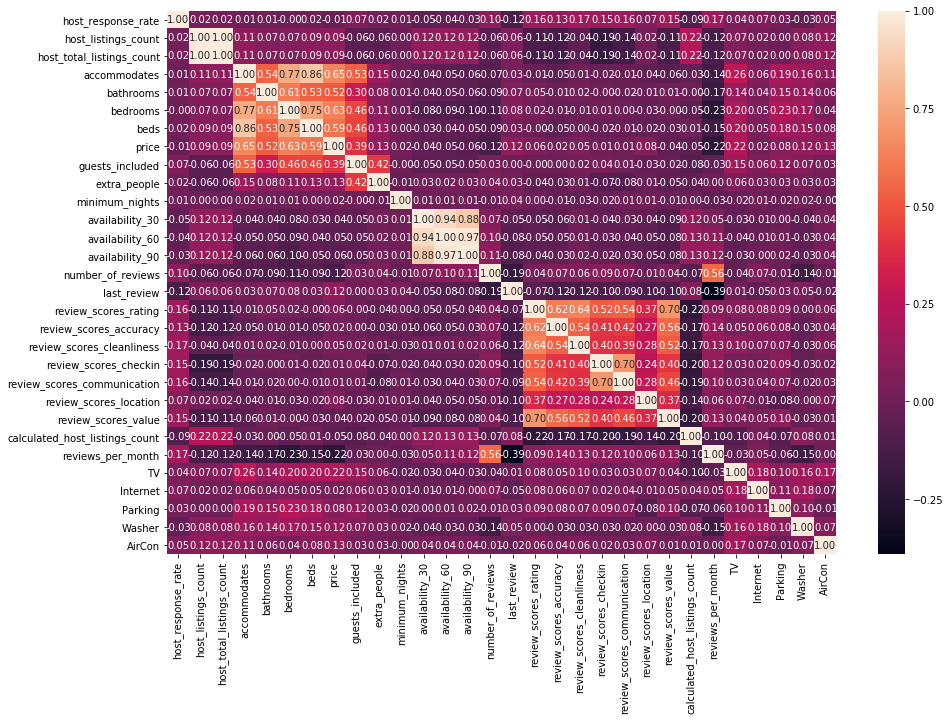

In [22]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(listings_rem_char_num.loc[:, :].corr(), annot=True, fmt='.2f')

## Dropping all review and availability columns as I dont want to measure their impact on price

In [23]:
drop_list= listings_rem_char_num.columns[listings_rem_char_num.columns.str.contains("review") | listings_rem_char_num.columns.str.contains("availability")].tolist()
drop_list

['availability_30',
 'availability_60',
 'availability_90',
 'number_of_reviews',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [0]:
# Drop from table
listings_rem_char_num.drop(drop_list, axis=1, inplace=True)


In [25]:
# Look at the missing values for each numeric variables -  shortlisted ones from previous steps

listings_rem_char_num.loc[:,listings_rem_char_num.columns[listings_rem_char_num.dtypes != "object"]].isnull().sum(axis=0)

host_response_rate                523
host_listings_count                 2
host_total_listings_count           2
accommodates                        0
bathrooms                          16
bedrooms                            6
beds                                1
price                               0
guests_included                     0
extra_people                        0
minimum_nights                      0
calculated_host_listings_count      0
TV                                  0
Internet                            0
Parking                             0
Washer                              0
AirCon                              0
dtype: int64

In [0]:
# Replace missing value with median of the column - median is more robust to outliers

cols = listings_rem_char_num.columns[listings_rem_char_num.dtypes != "object"]

listings_rem_char_num[cols]=listings_rem_char_num[cols].fillna(listings_rem_char_num.median().iloc[0])

In [27]:
#  Checking missing rows
listings_rem_char_num.loc[:,listings_rem_char_num.columns[listings_rem_char_num.dtypes != "object"]].isnull().sum(axis=0)

host_response_rate                0
host_listings_count               0
host_total_listings_count         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
price                             0
guests_included                   0
extra_people                      0
minimum_nights                    0
calculated_host_listings_count    0
TV                                0
Internet                          0
Parking                           0
Washer                            0
AirCon                            0
dtype: int64

# Final data from treatment of both categorical and numerical columns  is ready

## 1. Exploratory Analysis of Characater Variables 

### Plotting countplots from sns for all categorical variables

In [0]:
def plot_cats():
    ''' Plot all categorical variables using countplot'''
    plot_data= listings_rem_char_num.loc[:, listings_rem_char_num.columns[listings_rem_char_num.dtypes == "object"]]
    
    fig, axs = plt.subplots(int(np.ceil(plot_data.shape[1] / 2 )) ,2, figsize=(22,40))
    plt.subplots_adjust(hspace=0.8)
    for x in range(plot_data.shape[1]):
      g = sns.countplot(plot_data.iloc[:,x], ax = axs[int(x/2), x %2])      
      g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right")

      
    

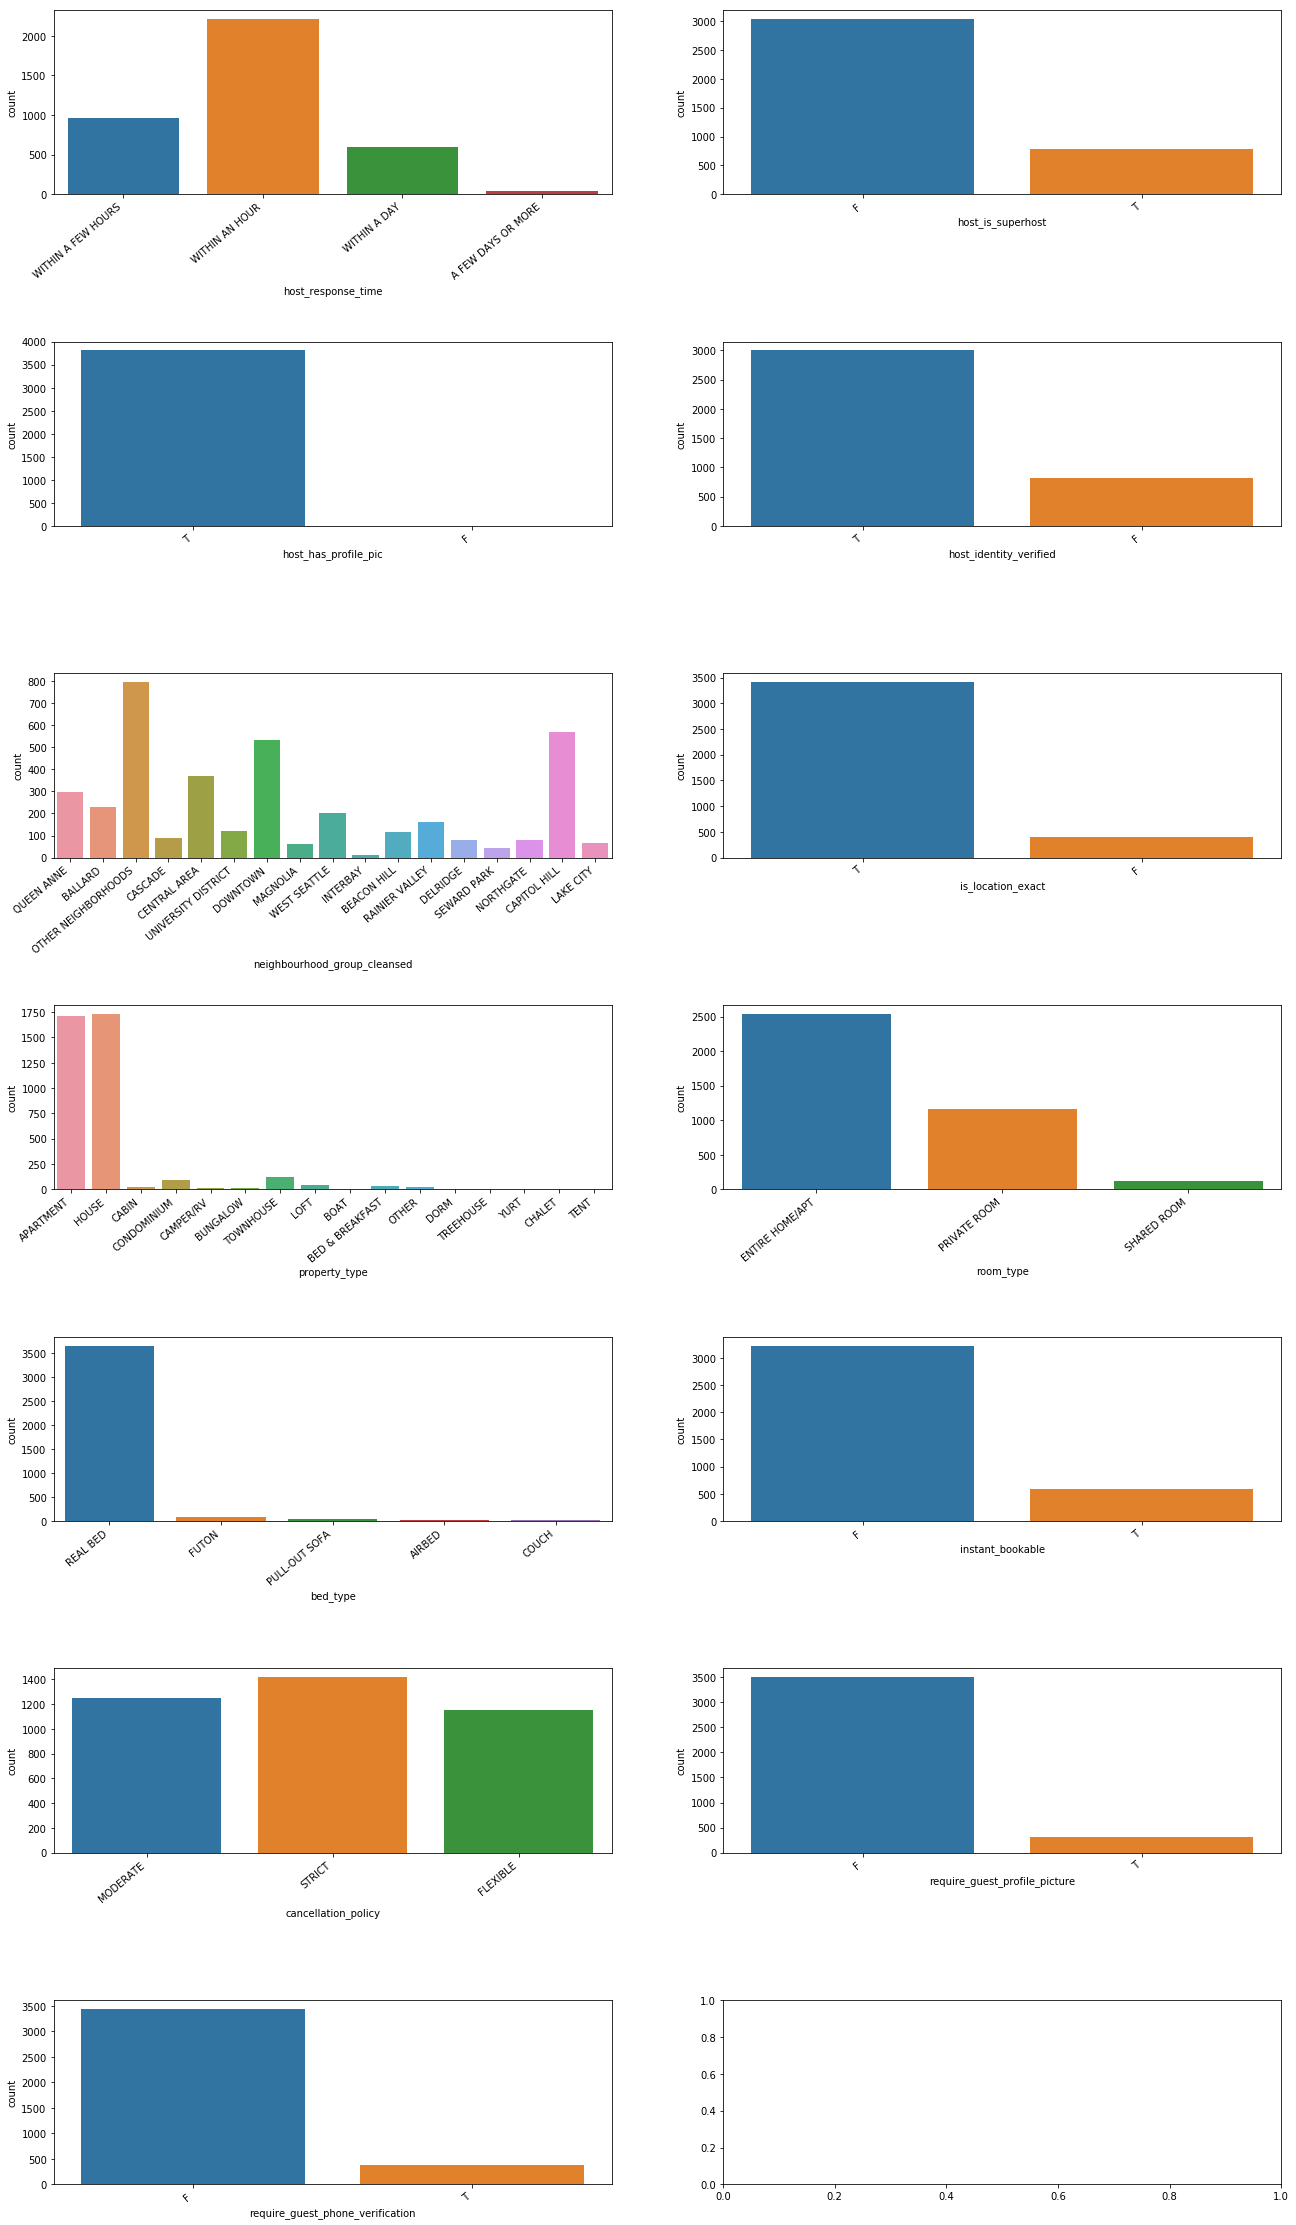

In [29]:
plot_cats()


## Plotting pairplot of price with all numerical variables

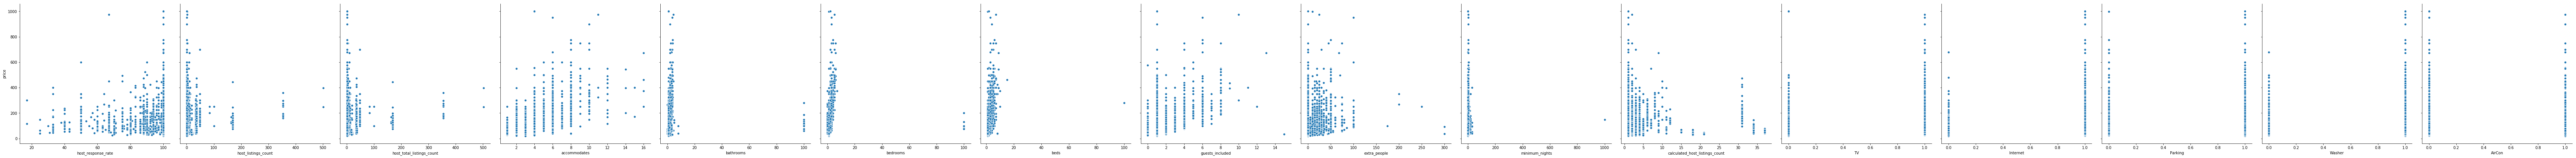

In [30]:
plot_data= listings_rem_char_num.loc[:, listings_rem_char_num.columns[listings_rem_char_num.dtypes != "object"]]
corr_list= plot_data.columns.tolist()
corr_list.remove('price')

g = sns.pairplot(plot_data, height=6, 
                 x_vars=corr_list,
                 y_vars=["price"])

plt.show()

# Getting  data ready to model

In [0]:
# Subset for only 'HOUSE', 'APARTMENT', 'TOWNHOUSE', 'CONDOMINIUM' - from the countplot above

final_ds=listings_rem_char_num.loc[listings_rem_char_num['property_type'].isin(['HOUSE', 'APARTMENT', 'TOWNHOUSE', 'CONDOMINIUM']),:]

In [0]:
# One Hot Encoding for Variables

final_ds_model = pd.get_dummies(final_ds, drop_first=True)

In [0]:
# Creating Predictor and Label data
predictors=final_ds_model.drop(['price'], axis=1)
outcome=final_ds_model.price

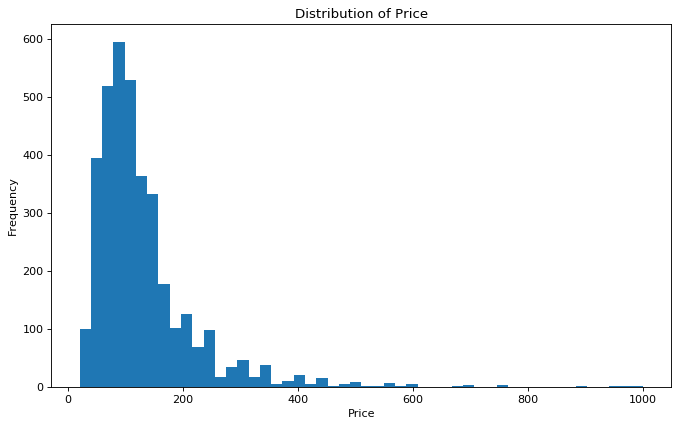

In [34]:
# Histogram of Price
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')

# Investigate distribution of price.
plt.hist(outcome, bins=50)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

#Question 1. Can we predict listing price using the information available?

## I am going to try Linear Regressor, Support Vector Regressor and Random Forest Regressor to see if we can get a decent model to predict price using the independent variables

# Follow Model Steps

In [35]:
# Split data betwene train and test
X_train, X_test, Y_train, Y_test= train_test_split(predictors, outcome,test_size = 0.25,random_state = 0)
X_train.shape,X_test.shape

((2738, 53), (913, 53))

In [0]:
# Standardize and transform training data
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)

#transform test data
X_test=scaler.transform(X_test)

## 1. Fitting a Linear Regressor 

In [37]:
# fitting a linear model

lm_model = LinearRegression(normalize=False) # Instantiate
lm_model.fit(X_train, Y_train) #Fit
        
#Predict and score the model
Y_train_preds = lm_model.predict(X_train) 
Y_train_preds, Y_train

Y_test_preds = lm_model.predict(X_test)

print("The r-squared score for your model on train data was {} on {} values.".format(r2_score(Y_train, Y_train_preds), len(Y_train)))
print("The r-squared score for your model on test data was {} on {} values.".format(r2_score(Y_test, Y_test_preds), len(Y_test)))

print("The mse for your model on train data was {} on {} values.".format(mean_squared_error(Y_train, Y_train_preds), len(Y_train)))
print("The mse for your model on test data was {} on {} values.".format(mean_squared_error(Y_test, Y_test_preds), len(Y_test)))



The r-squared score for your model on train data was 0.5040125681508151 on 2738 values.
The r-squared score for your model on test data was 0.5230898959314152 on 913 values.
The mse for your model on train data was 3910.1473192230897 on 2738 values.
The mse for your model on test data was 4183.1269328201015 on 913 values.


# Question 2 : Can we find out the most important drivers to listing price?

# Important  Influencers for Listing Price from Linear Regressor

In [38]:
Var_coeff={ 'index' : predictors.columns , 
      'Coeff'  : lm_model.coef_}


Var_coeff = pd.DataFrame(Var_coeff)

Var_coeff.sort_values(by='Coeff', ascending=False, inplace=True)
Var_coeff.head(10)



,index,Coeff
2,host_total_listings_count,8.394561e+13
3,accommodates,4.387982e+01
27,neighbourhood_group_cleansed_DOWNTOWN,1.126096e+01
40,property_type_HOUSE,9.968750e+00
23,neighbourhood_group_cleansed_CAPITOL HILL,8.269137e+00
33,neighbourhood_group_cleansed_QUEEN ANNE,7.519531e+00
6,beds,5.247952e+00
51,require_guest_profile_picture_T,4.416016e+00
41,property_type_TOWNHOUSE,3.691406e+00
7,guests_included,3.444773e+00


##  Form the regression coeffecients we can see Host Listings Count, space (accomodates) and neighbourhood group looks to influencing AIRBnB Listing Price

## Plotting Predicted Vs. Residual

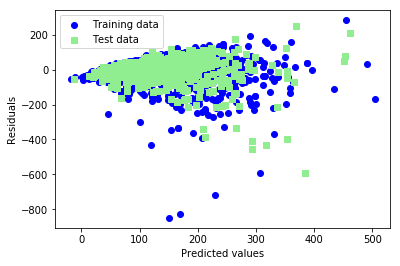

In [39]:
plt.scatter(Y_train_preds,  Y_train_preds - Y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(Y_test_preds,  Y_test_preds - Y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.show()

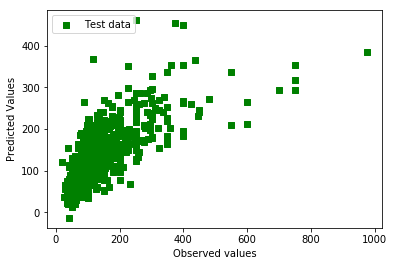

In [40]:
plt.scatter( Y_test,Y_test_preds, 
            c='green', marker='s', label='Test data')
plt.xlabel('Observed values')
plt.ylabel('Predicted Values')
plt.legend(loc='upper left')
plt.show()

## Trying SVR model

In [0]:
# Lets run an advanced model  - Random forest and SVM
param=[{'C': [0.1, 0.5, 1,10], 'kernel' :['linear']}, 
       {'C': [0.1, 0.5,1,10], 'degree' : [1,2,3,4], 'kernel': ['poly']},
       {'C': [0.1, 0.5,1,10], 'gamma' : [0.1,0.5,0.01], 'kernel': ['rbf']}]


SVR_final=SVR()
scores = make_scorer(r2_score)
svr_obj=GridSearchCV(SVR_final, param, scoring=scores)

svr_fit=svr_obj.fit(X_train, Y_train)
svr_grid = svr_fit.best_estimator_
svr_grid

In [42]:
Y_train_preds= svr_grid.predict(X_train)
Y_test_preds= svr_grid.predict(X_test)

print("The r-squared score for your model on train data was {} on {} values.".format(r2_score(Y_train, Y_train_preds), len(Y_train)))
print("The r-squared score for your model on test data was {} on {} values.".format(r2_score(Y_test, Y_test_preds), len(Y_test)))

print("The mse for your model on train data was {} on {} values.".format(mean_squared_error(Y_train, Y_train_preds), len(Y_train)))
print("The mse for your model on test data was {} on {} values.".format(mean_squared_error(Y_test, Y_test_preds), len(Y_test)))


The r-squared score for your model on train data was 0.4458984127811464 on 2738 values.
The r-squared score for your model on test data was 0.4566431271582271 on 913 values.
The mse for your model on train data was 4368.293825033583 on 2738 values.
The mse for your model on test data was 4765.952219352551 on 913 values.


## Trying Random Forest Regressor

In [43]:
param={"max_depth": [2,5,10],
       "n_estimators" : [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)],
      }

RF_final=RandomForestRegressor()
scores = make_scorer(r2_score)
rfr_obj=GridSearchCV(RF_final, param, scoring=scores)

rfr_fit=rfr_obj.fit(X_train, Y_train)
rfr_grid = rfr_fit.best_estimator_
rfr_grid

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=155,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [44]:
Y_train_preds= rfr_grid.predict(X_train)
Y_test_preds= rfr_grid.predict(X_test)

print("The r-squared score for your model on train data was {} on {} values.".format(r2_score(Y_train, Y_train_preds), len(Y_train)))
print("The r-squared score for your model on test data was {} on {} values.".format(r2_score(Y_test, Y_test_preds), len(Y_test)))

print("The mse for your model on train data was {} on {} values.".format(mean_squared_error(Y_train, Y_train_preds), len(Y_train)))
print("The mse for your model on test data was {} on {} values.".format(mean_squared_error(Y_test, Y_test_preds), len(Y_test)))


The r-squared score for your model on train data was 0.6389814629454217 on 2738 values.
The r-squared score for your model on test data was 0.6306929207620899 on 913 values.
The mse for your model on train data was 2846.1117645477707 on 2738 values.
The mse for your model on test data was 3239.3073169593868 on 913 values.


# Important Influencers for Listing Price from Random Forest Regressor


In [45]:
RF_coeff={ 'Columns' : predictors.columns , 
      'Coeff'  :rfr_grid.feature_importances_}


RF_coeff = pd.DataFrame(RF_coeff)

RF_coeff.sort_values(by='Coeff', ascending=False, inplace=True)
RF_coeff.head(10)


,Columns,Coeff
5,bedrooms,0.575815
4,bathrooms,0.105442
3,accommodates,0.081816
42,room_type_PRIVATE ROOM,0.051971
27,neighbourhood_group_cleansed_DOWNTOWN,0.038725
8,extra_people,0.026383
43,room_type_SHARED ROOM,0.025984
7,guests_included,0.007663
33,neighbourhood_group_cleansed_QUEEN ANNE,0.007503
1,host_listings_count,0.007221


In [71]:
Y_test_preds_lr = lm_model.predict(X_test) 

Y_test_preds_svr = svr_grid.predict(X_test)

Y_test_preds_rfr = rfr_grid.predict(X_test)

results_LR=pd.DataFrame([{'Algorithm' : 'LinearRegressor' , 'R2Score' : round(r2_score(Y_test, Y_test_preds_lr),2), 'MSE' : round(mean_squared_error(Y_test, Y_test_preds_lr),2)}])
results_SVR=pd.DataFrame([{'Algorithm' : 'SupportVectorRegressor' , 'R2Score' : round(r2_score(Y_test, Y_test_preds_svr),2), 'MSE' : round(mean_squared_error(Y_test, Y_test_preds_svr),2)}])
results_RFR=pd.DataFrame([{'Algorithm' : 'RandomForestRegressor' , 'R2Score' : round(r2_score(Y_test, Y_test_preds_rfr),2), 'MSE' : round(mean_squared_error(Y_test, Y_test_preds_rfr),2)}])
results=results_LR.append([results_SVR, results_RFR], sort=False, ignore_index=True)
results

,Algorithm,MSE,R2Score
0,LinearRegressor,4183.13,0.52
1,SupportVectorRegressor,4765.95,0.46
2,RandomForestRegressor,3239.31,0.63


# Conclusion for Question 1 and Question 2:

With the different models tried, random forest has the best result - it is able to  capture 63% of variance in the data. I was able to get an r2score of 0.63 on both training and test data sets.

Looking at the scatter plot of residuals in the linear regressor, there looks to be a autocorrelation between listings  as the residual plot diverges from left to right meaning the error is not constant. 

For both the Linear regressor and RF, space in the property ( bedrooms, accomodates, extra people) is an important driver for the price. Neighbourhood  group and host listings are also coming out as key drivers of the price.




#  Question 3 :  Are the factors influencing price also influence reviews?

In [46]:
  reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [47]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
# SentimentIntensityAnalyzer reference: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    sentence = str(sentence)
    score = analyser.polarity_scores(sentence)
    return score['compound']
  

In [49]:
reviews['polarity_score'] = reviews['comments'].apply(sentiment_analyzer_scores)
reviews['sentiment'] = np.where(reviews['polarity_score'] > 0, 'positive', np.where(reviews['polarity_score'] == 0, 'neutral', 'negative'))
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity_score,sentiment
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,0.7901,positive
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,0.9872,positive
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",0.8718,positive
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,0.8313,positive
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,0.9783,positive


In [0]:
# Combine all the information together
listings_review= pd.merge(reviews, listings_rem_char, how='inner', on=None, left_on=['listing_id'], right_on=['id'])

In [51]:
listings_review['sentiment'].value_counts()

positive    82444
neutral      1556
negative      849
Name: sentiment, dtype: int64

# Lets look at polarity for each neighbourhood group

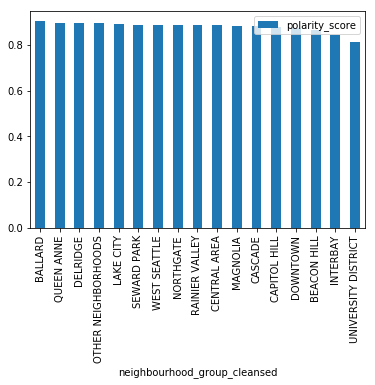

In [55]:
neighour_polarity = listings_review.groupby('neighbourhood_group_cleansed')[['polarity_score']].mean().sort_values(by='polarity_score',ascending=False)

neighour_polarity.head(20).plot(kind='bar')

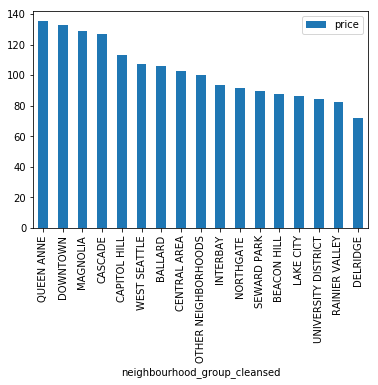

In [57]:
neighour_price = listings_review.groupby('neighbourhood_group_cleansed')[['price']].mean().sort_values(by='price',ascending=False)

neighour_price.head(20).plot(kind='bar')

# Polarity with space information

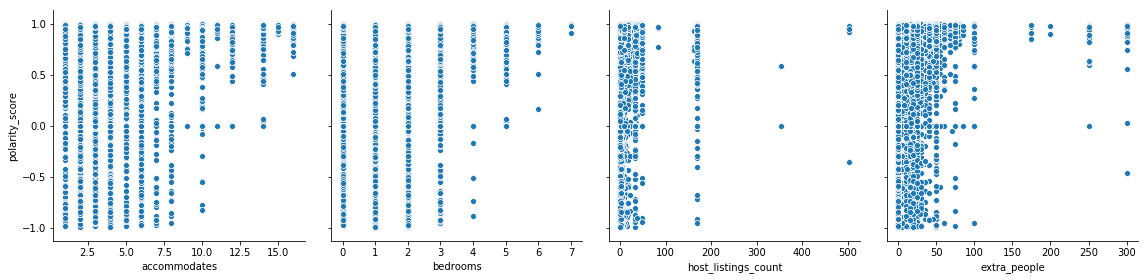

In [58]:
plot_data= listings_review.loc[:, ['accommodates','bedrooms', 'host_listings_count', 'extra_people','polarity_score']]

g = sns.pairplot(plot_data, height=4,
                 x_vars=['accommodates','bedrooms', 'host_listings_count', 'extra_people'],
                 y_vars=["polarity_score"])

plt.show()

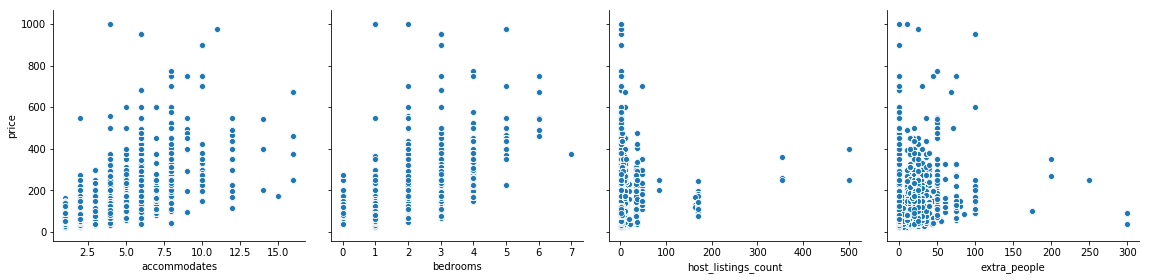

In [59]:
plot_data= listings_review.loc[:, ['accommodates','bedrooms', 'host_listings_count', 'extra_people','polarity_score', 'price']]

g = sns.pairplot(plot_data, height=4,
                 x_vars=['accommodates','bedrooms', 'host_listings_count', 'extra_people'],
                 y_vars=["price"])

plt.show()

# Conclusion 3 :
Most of neighbourhood have similar polarity score, so we can't say if neighbourhood influence price, they would also influence reviews. Space of the property however is showing a trend with reviews as we observe polarity score being more positive as property space increases.